In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,8]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Thesis datasets/Weekly_Pharmaceutical_sales.csv')
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,1/5/2014,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,1/12/2014,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,1/19/2014,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
3,1/26/2014,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
4,2/2/2014,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


In [ ]:
df.tail()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
297,9/15/2019,35.51,30.977,19.65,178.375,67.2,5.0,30.000000,30.50
298,9/22/2019,46.84,25.396,24.40,248.250,31.2,3.0,26.000000,21.00
299,9/29/2019,34.01,22.498,26.60,336.700,61.2,1.0,40.416667,23.10
300,10/6/2019,38.70,32.502,19.25,249.450,69.0,5.0,30.000000,12.13
301,10/13/2019,7.67,6.237,3.50,95.100,26.0,2.0,12.000000,1.00


In [ ]:
df.shape

(302, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   datum   302 non-null    object 
 1   M01AB   302 non-null    float64
 2   M01AE   302 non-null    float64
 3   N02BA   302 non-null    float64
 4   N02BE   302 non-null    float64
 5   N05B    302 non-null    float64
 6   N05C    302 non-null    float64
 7   R03     302 non-null    float64
 8   R06     302 non-null    float64
dtypes: float64(8), object(1)
memory usage: 21.4+ KB


In [ ]:
time = pd.date_range(start='1/5/2014',periods=302,freq='W')
df['time_stamp'] = pd.DataFrame(time)
df.drop('datum',axis=1,inplace=True)
df = df.set_index('time_stamp')

In [ ]:
df.head()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
time_stamp,,,,,,,,
2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


In [ ]:
df.tail()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
time_stamp,,,,,,,,
2019-09-15,35.51,30.977,19.65,178.375,67.2,5.0,30.000000,30.50
2019-09-22,46.84,25.396,24.40,248.250,31.2,3.0,26.000000,21.00
2019-09-29,34.01,22.498,26.60,336.700,61.2,1.0,40.416667,23.10
2019-10-06,38.70,32.502,19.25,249.450,69.0,5.0,30.000000,12.13
2019-10-13,7.67,6.237,3.50,95.100,26.0,2.0,12.000000,1.00


In [ ]:
df = df[['N02BE']]
df

,N02BE
time_stamp,
2014-01-05,185.950
2014-01-12,190.700
2014-01-19,218.400
2014-01-26,179.600
2014-02-02,159.880
...,...
2019-09-15,178.375
2019-09-22,248.250
2019-09-29,336.700


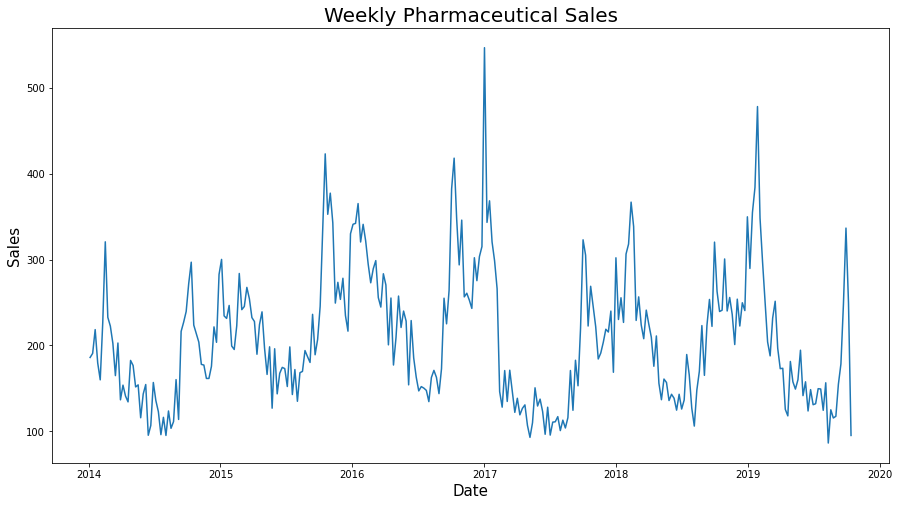

In [ ]:
plt.plot(df)
plt.title('Weekly Pharmaceutical Sales',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Sales',fontsize=15)
plt.show()

In [ ]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [170]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['N02BE'] = df['N02BE'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0, 1))#LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

In [173]:
#Split data set into testing dataset and train dataset
train_size = 266
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 5
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [174]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(261, 1, 5)
(261,)
(31, 1, 5)
(31,)


In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 9.3 MB/s 


In [ ]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,Bidirectional,BatchNormalization,LeakyReLU
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('first_lstm_layer',min_value=16,max_value=256,step=16), activation="relu",return_sequences=True, input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    model.add(LSTM(hp.Int('final_lstm_layer',min_value=16,max_value=256,step=16),activation="relu",recurrent_dropout = hp.Choice("last_recurrent_dropout",[0.2,0.4,0.6],default=0.4) ))
    model.add(Dense(hp.Int('dense_layer_1',min_value=16,max_value=256,step=16),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate_1',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=2,
    directory='project',
    project_name='pharma Sales_4')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
first_lstm_layer (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
final_lstm_layer (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
last_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
Dropout_rate_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=30,
             validation_data=(testX, testY))

Trial 20 Complete [00h 00m 47s]
val_mape: 21.361492156982422

Best val_mape So Far: 18.594181060791016
Total elapsed time: 00h 22m 28s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/pharma Sales_4
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
first_lstm_layer: 32
first_recurrent_dropout: 0.4
final_lstm_layer: 80
last_recurrent_dropout: 0.4
dense_layer_1: 240
Dropout_rate_1: 0.2
learning_rate: 0.00016836000714040867
Score: 18.594181060791016
Trial summary
Hyperparameters:
first_lstm_layer: 16
first_recurrent_dropout: 0.2
final_lstm_layer: 224
last_recurrent_dropout: 0.6
dense_layer_1: 80
Dropout_rate_1: 0.0
learning_rate: 0.00017541406166518252
Score: 20.200878143310547
Trial summary
Hyperparameters:
first_lstm_layer: 224
first_recurrent_dropout: 0.4
final_lstm_layer: 16
last_recurrent_dropout: 0.4
dense_layer_1: 64
Dropout_rate_1: 0.5
learning_rate: 0.0003472032849266493
Score: 20.823944091796875
Trial summary
Hyperparameters:
first_lstm_layer: 96
first_recurrent_dropout: 0.2
final_lstm_layer: 80
last_recurrent_dropout: 0.6
dense_layer_1: 96
Dropout_rate_1: 0.5
learning_rate: 0.

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 6))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 32)             4992      
                                                                 
 lstm_1 (LSTM)               (None, 80)                36160     
                                                                 
 dense (Dense)               (None, 240)               19440     
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 241       
                                                                 
Total params: 60,833
Trainable params: 60,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers

In [181]:
model = Sequential()
model.add(Bidirectional(LSTM(256,activation='relu',input_shape=(1,look_back),return_sequences=True)))
model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True)))
model.add(Bidirectional(LSTM(64,activation='relu',return_sequences=True)))
model.add(Bidirectional(LSTM(32,activation='relu')))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.00016836000714040867)
model.compile(optimizer = ad, loss = 'mae', metrics = ['mae'])
model_history=model.fit(trainX, trainY,validation_data=(testX, testY), batch_size = 30, epochs = 100)

Epoch 1/100
9/9 [==============================] - 15s 194ms/step - loss: 0.2761 - mae: 0.2761 - val_loss: 0.1596 - val_mae: 0.1596
Epoch 2/100
9/9 [==============================] - 0s 31ms/step - loss: 0.2723 - mae: 0.2723 - val_loss: 0.1560 - val_mae: 0.1560
Epoch 3/100
9/9 [==============================] - 0s 31ms/step - loss: 0.2682 - mae: 0.2682 - val_loss: 0.1520 - val_mae: 0.1520
Epoch 4/100
9/9 [==============================] - 0s 32ms/step - loss: 0.2635 - mae: 0.2635 - val_loss: 0.1475 - val_mae: 0.1475
Epoch 5/100
9/9 [==============================] - 0s 30ms/step - loss: 0.2581 - mae: 0.2581 - val_loss: 0.1425 - val_mae: 0.1425
Epoch 6/100
9/9 [==============================] - 0s 31ms/step - loss: 0.2516 - mae: 0.2516 - val_loss: 0.1365 - val_mae: 0.1365
Epoch 7/100
9/9 [==============================] - 0s 32ms/step - loss: 0.2433 - mae: 0.2433 - val_loss: 0.1289 - val_mae: 0.1289
Epoch 8/100
9/9 [==============================] - 0s 31ms/step - loss: 0.2320 - mae: 0.

In [182]:
def model_loss(history):
    plt.figure(figsize=(15,8))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train MAE: 32.18945891481114
Test MAE: 31.80354609033778


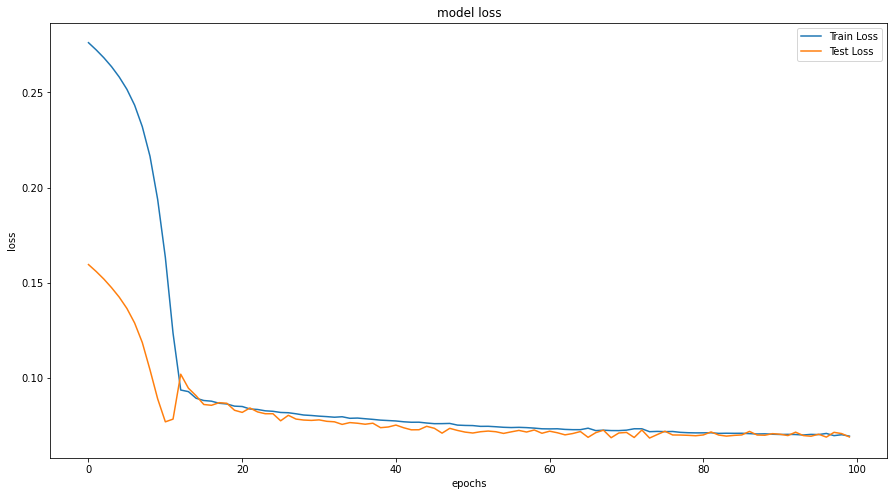

In [183]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print("Train MAE:",mae(trainY.reshape(-1,),train_predict.reshape(-1,)))
print("Test MAE:",mae(testY.reshape(-1,),test_predict.reshape(-1,)))
model_loss(model_history)

In [184]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(261,292)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

In [ ]:
import seaborn as sns

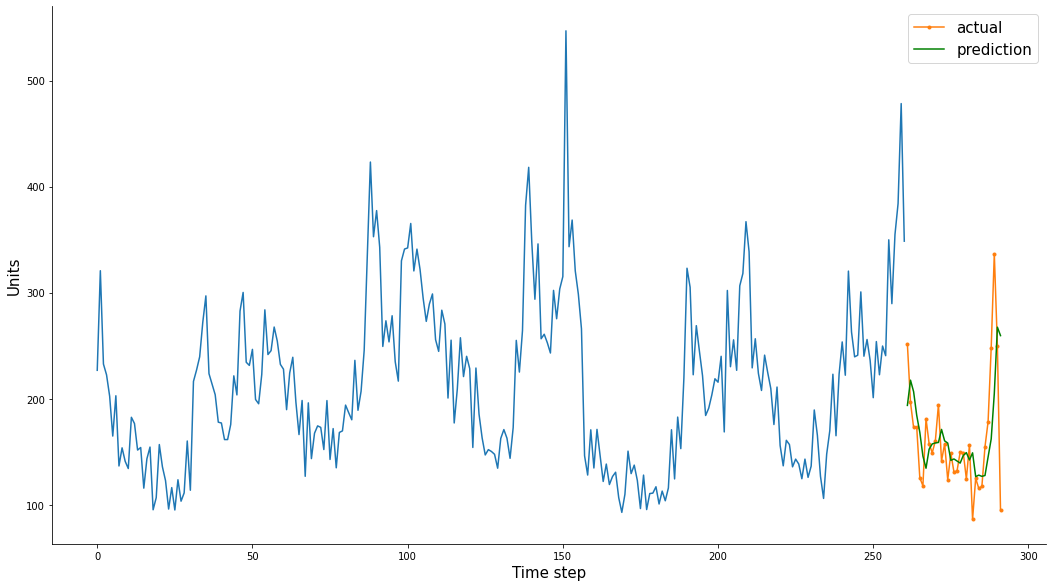

In [185]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)